In [1]:
%matplotlib inline
from __future__ import print_function
import numpy
import matplotlib.pyplot as plt

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel $\rightarrow$ Restart) and then run all cells (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says YOUR CODE HERE or "YOUR ANSWER HERE", as well as your name and collaborators below:

# HW 2:  Root Finding and Optimization

## Question 1 - Inverse Quadratic Interpolation

Let us see if we can extend the idea of the secant method to a higher order version.  The idea then is to take 3 values of the function such that $(x_0, f(x_0))$, $(x_1, f(x_1))$, and $(x_2, f(x_2))$ and fit an inverse quadratic function through these points (note that this requires that $f(x_i) \neq f(x_j) \forall i \neq j$).  The inverse function can be written as
$$
    g(y) = x_2 + \frac{(y - f(x_1)) (y - f(x_2))(x_0 - x_2)}{(f(x_0) - f(x_1))(f(x_0) - f(x_2))} + \frac{(y - f(x_0)) (y - f(x_2))(x_1 - x_2)}{(f(x_1) - f(x_0))(f(x_1) - f(x_2))}
$$
Inverse quadratic interpolation is one of the core components of many root solvers in libraries such as `numpy`.

Using this new function answer the following questions.

**(a)** (10 points) Find the x-intercept of the function $g(y)$ and use this to find the iteration scheme of the form
$$
    x_{n+1} = x_n + \phi(x_n, x_{n-1}, x_{n-2})
$$
where $\phi(x_n, x_{n-1}, x_{n-2})$ can also contain evaluations of the original function $f(x)$.

Substitute $y = 0$ into the equation
$$
\begin{align}
g(y) = x_2 + \frac{f(x_1)f(x_2)(x_0 - x_2)}{(f(x_0) - f(x_1))(f(x_0) - f(x_2))} + \frac{f(x_0) f(x_2)(x_1 - x_2)}{(f(x_1) - f(x_0))(f(x_1) - f(x_2))}
\end{align}
$$

If we take our $x_0, x_1, x_2$ to be our values of $x_{n-2}, x_{n-1}, x_n$ respectivly, we can find the recurrence relation for this scheme.

$$
x_{n+1} = x_n + \frac{f(x_{n-1})f(x_n)}{(f(x_{n-2}) - f(x_{n-1}))(f(x_{n-2}) - f(x_n))}(x_{n-2} - x_n) + \frac{f(x_{n-2}) f(x_n)}{(f(x_{n-1}) - f(x_{n-2}))(f(x_{n-1}) - f(x_n))}(x_{n-1} - x_n)
$$

**(b)** (10 points) Write a function that implements the inverse quadratic interpolation root finding method which takes in a function $f$ and an initial triplet for an initial guess $(x_0, x_1, x_2)$.  Make sure that it handles the case when the maximum number of steps is taken.

In [2]:
from collections import deque

def inv_quad_root(f, x, tolerance=1e-4, max_steps=100):
    """Find a root of f(x) using inverse quadratic interpolation
    
    :Input:
     - *f* (func) Function to find the root of.
     - *x* (list) A triplet of values to be used to start the method.  Note
       that the triplet starts with the x_0 value and ends with the x_2 value
       in terms of the iteration scheme.
     - *tolerance* (float) Tolerance used as a stopping criteria with 
       |f(x_n)| < tolerance.
     - *max_steps* (int) Maximum number of steps allowed.  Raise an exception
       if max_steps are reached.
    :Output:
     - (float) Converged root.
    """
    
    # Use deque for easy index flipping
    x = deque(x)
    steps = 0
    while x[2] > tolerance and steps < max_steps:
        # Calculate the coef for the x_{n-2} - x_n term
        coefn2 = (f(x[1]) * f(x[2])) / ((f(x[0]) - f(x[1])) * (f(x[0]) - f(x[2])))
        
        # Calculate the coef for the x_{n-1} - x_n term
        coefn1 = (f(x[0]) * f(x[2])) / ((f(x[1]) - f(x[0])) * (f(x[1]) - f(x[2])))
        
        # Calculate the new x_n term
        new_term = x[2] + coefn2 * (x[0] - x[2]) + coefn1 * (x[1] - x[2])
        
        # Pop the oldest term and add the new term
        x.popleft()
        x.append(new_term)
        
        # Keep track of the steps
        steps += 1
    return x[2]

In [3]:
P = 1500.0
m = 12
n = 20.0
A = 1e6
f = lambda r, A=A, m=m, P=P, n=n: A - m * P / r * ((1.0 + r / m)**(m * n) - 1.0)
root = inv_quad_root(f, [0.06, 0.07, 0.08], tolerance=1e-6, max_steps=10)
print("Found root = %s" % root)
numpy.testing.assert_allclose(root, 0.08985602483470391, atol=1e-5)
print("Success!")

Found root = 0.08985602483469936
Success!


## Question 2 - Bessel Function Zeros

The zeros of the Bessel functions $J_0(x)$ can be important for a number of applications.  Considering only $x \geq 0$ 
we are going to find the first ten zeros of $J_0(x)$ by using a hybrid approach.

**(a)** (5 points) Plot the Bessel function $J_0(x)$ and its zeros on the same plot.  Note that the module `scipy.special` contains functions dealing with the Bessel functions (`jn`).

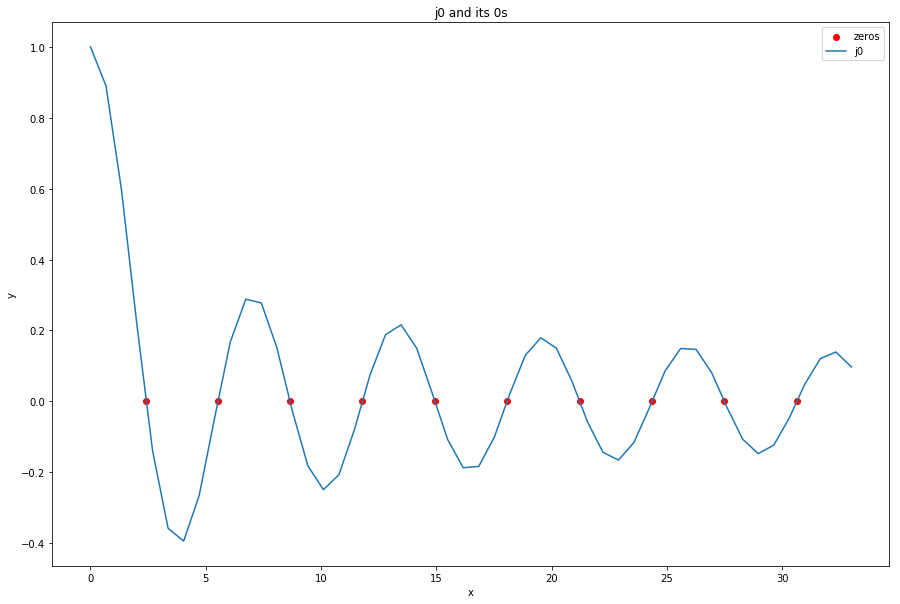

In [4]:
from scipy.special import j0, jn_zeros

x = numpy.linspace(0, 33)
plt.figure(figsize=(15,10))
zeros = plt.scatter(jn_zeros(0, 10), numpy.zeros(10), color='red')
bessel, = plt.plot(x, j0(x))
plt.legend([zeros, bessel], ['zeros', 'j0'])
plt.title('j0 and its 0s')
plt.xlabel('x')
plt.ylabel('y')

**(b)** (15 points) Now write a function `j0_zeros` that takes two tolerances, a bracket size tolerance `bracket_tolerance` and `tolerance` for the final convergence tolerance.  Given an initial bracket, the function should perform secant iterations until the bracket size is less than `bracket_tolerance`.  If this is successful then proceed with Newton's method using the newest value of the bracket until `tolerance` is reached.  Return both the zero found and the number of steps needed in each iteration.  Also write a `doc-string` for the function.

Notes:
 - Newton's method by itself does not work here given the initial brackets provided.
 - The secant method does work however it is slower than the approach outlined.
 - Try playing a bit yourself with the tolerances used.

In [5]:
import scipy.special
from scipy.special import j0, jvp

def j0_zeros(x0, bracket_tolerance, tolerance):
    """
    Find the 0 within a given bracket for the j0 bezel function.
    Starts by applying the secant method until the bracket_tolerance
    is reached at which point it switches to newtons method
    until the tolerance is reached
    
    Parameters
    ----------
    x0: list
        The bracket to find the max between
    bracket_tolerance: float
        The minimum bracket size before switching to newtons method
    tolerance: float
        The mimimum bracket size before returning the value
        
    Returns
    -------
    (x, num steps): tuple
        x: The value of x where j0 has a zero. 
        y : The number of steps of each method [secant, newtons]
        
    """
    num_steps = [0, 0]
    f = lambda x: j0(x)
    
    x_1 = x0[0]
    x_2 = x0[1]
    f_1 = f(x_1)
    f_2 = f(x_2)
    x = 3
    # Begin with secant method
    while(abs(x_2 - x_1) > bracket_tolerance):
        # Calculate the next term
        x = x_2 - f_2 * ((x_2 - x_1) / (f_2 - f_1))
        num_steps[0] += 1
        
        # Check to see if we are done
        if abs(f(x)) < tolerance:
            return x, num_steps
        
        # Update f terms
        x_1 = x_2
        x_2 = x
        f_1 = f(x_1)
        f_2 = f(x_2)

    
    # If we are not done continue to newton's method
    f_prime = lambda x: jvp(0, x)
    while(abs(f(x)) > tolerance):
        x = x - f(x) / f_prime(x)
        num_steps[1] += 1

    return x, num_steps

In [6]:
brackets = [[ 2.0,  3.0], [ 4.0,  7.0], [ 7.0, 10.0], [10.0, 12.0], 
            [13.0, 15.0], [17.0, 19.0], [19.0, 22.0], 
            [22.0, 26.0], [26.0, 29.0], [29.0, 32.0]]

zero = []
for bracket in brackets:
    x, num_steps = j0_zeros(bracket, 1e-1, 1e-15)
    print(x, num_steps)
    zero.append(x)
numpy.testing.assert_allclose(zero, scipy.special.jn_zeros(0, 10), rtol=1e-14)
print("Success!")

2.4048255577 [2, 3]
5.52007811029 [4, 2]
8.65372791291 [2, 3]
11.791534439 [3, 2]
14.9309177085 [2, 2]
18.0710639679 [2, 2]
21.2116366299 [3, 2]
24.3524715307 [4, 2]
27.493479132 [2, 3]
30.6346064684 [3, 2]
Success!


## Question 3 - Newton's Method Convergence

Recall that Newton's method converges as

$$|\epsilon_{n+1}| = \frac{|f''(c)|}{2 |f'(x_n)|} |\epsilon_n|^2$$

with $\epsilon_n = x_n - x^*$ where $x^*$ is the true solution and $c$ is between $x_n$ and $x^*$.

**(a)** (10 points) Show that the Newton iteration when $f(x) = x^2 - M$ with $M > 0$ is

$$x_{n+1} = \frac{1}{2} \left (x_n + \frac{M}{x_n} \right )$$

A Newton's method step is defined $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$ so we simply plug and push to the given form

$$
\begin{align}
x_{n+1} &= x_n - \frac{f(x_n)}{f'(x_n)} \\
&= x_n - \frac{x_n^2 - M}{2x_n} \\
&= x_n - \frac{x_n}{2} + \frac{M}{2x_n} \\
&= \frac{1}{2}x_n + \frac{1}{2}\frac{M}{x_n} \\
&= \frac{1}{2}(x_n + \frac{M}{x_n})
\end{align}
$$

**(b)** (10 points) From this update scheme show that 

$$\frac{x_{n+1} - \sqrt{M}}{(x_n - \sqrt{M})^2} = \frac{1}{2 x_n}$$

$$
\begin{align}
\frac{x_{n+1} - \sqrt{M}}{(x_n - \sqrt{M})^2} &= \frac{\frac{1}{2}(x_n + \frac{M}{x_n}) - \sqrt{M}}{(x_n - \sqrt{M})^2} \\
  &= \frac{\frac{x_n}{2} + \frac{M}{2x_n} - \sqrt{M}}{(x_n - \sqrt{M})^2} \\
&= \frac{\frac{1}{2x_n}(x_n^2 + M - 2x_n\sqrt{M})}{(x_n - \sqrt{M})^2} \\
&= \frac{\frac{1}{2x_n}(x_n - \sqrt{M})^2}{(x_n - \sqrt{M})^2} \\
&= \frac{1}{2x_n}
\end{align}
$$


**(c)** (10 points) Confirm that the asymptotic error convergence matches the general convergence for Newton's method.

We first show that the function matches our general case and converges quadratically. In part (a) we found $x_{n+1} = g(x_n) = \frac{1}{2}(x_n + \frac{M}{x_n})$ and we can use this specific g(x) to show that we converge quadratically. Note that we set $ x_{n+1} = x^* + \epsilon_{n+1}$ and $x_n = x^* + \epsilon_n$ where $x^*$ is the true solution where $f(x^*) = 0$.


We begin by deriving an expression for $\epsilon_{n+1}$ by using a taylor expansion
$$
\begin{align}
x^* + \epsilon_{n+1} &= g(x^* + \epsilon_n) = g(x^*) + g'(x^*)\epsilon_n + \frac{g''(x^*)\epsilon_n^2}{2!} + O(\epsilon_n^3)\\
\epsilon_{n+1} &= g(x^*) - x^* + g'(x^*)\epsilon_n + \frac{g''(x^*)\epsilon_n^2}{2!} + O(\epsilon_n^3)\\
\end{align}
$$

Now we show that the terms $g(x^*) - x^*$ and $g'(x^*)\epsilon_n$ go to 0.


For the $g(x^*) - x^*$ term, we know that, since $f(x^*) = 0$ by definition, $M - {x^*}^2 = 0$. We can then use this fact to show the term vanishes.

$$
\begin{align}
g(x^*) - x^* &= \frac{1}{2}(x^* + \frac{M}{x^*}) - x^* \\
&= \frac{{x^*}^2 + M}{2x^*} - x^* \\
&= \frac{{x^*}^2 + M - 2{x^*}^2}{2x^*} \\
&= \frac{M - {x^*}^2}{2x^*} \\
&= \frac{0}{2x^*} \\
&= 0
\end{align}
$$

For the $g'(x^*)\epsilon_n$ term, again since $f(x^*) = 0$, We can derive the relationship $\frac{M}{{x^*}^2} = 1$. Again we use this to show that the term vanishes.

$$
\begin{align}
g'(x^*) &= \frac{1}{2}(1 - \frac{M}{{x^*}^2}) \\
&= \frac{1}{2}(1 - 1) \\
&= 0
\end{align}
$$


Now all that is left is to show that  $\frac{g''(x^*)}{2!}$ does not vanish
$$
\begin{align}
\frac{g''(x^*)}{2!} &= \frac{M}{2{x^*}^3}
\end{align}
$$

Which we can clearly non 0, so we are left with the relationship:
$$
\epsilon_{n+1} = \frac{g''(x^*)}{2!}\epsilon_n^2 + O(\epsilon_n^3)\\
$$

Which matches the quadratic convergence of our general expression.

Next we show that the coefficient for rate of convergence matches the general case. By definition, for a quadratically converging iterative method the asymptotic error constant is calculated.

$$
lim_{x\to\infty}\frac{|x_{n+1} - x^*|}{|x_n - x^*|^2}
$$

We can see that this matches what we found in part (b) without the absolute values as $x^* = \sqrt M$. Thus our calculated asymptotic error constant is $$\frac{1}{2|x_n|}$$ Now we check that this matches our general form by differentiating f(x) and sticking those values into our general form.

$$
\begin{align}
f(x) &= x^2 + M \\
f'(x) &= 2x \\
f''(x) &= 2
\end{align}
$$

$$
\frac{|f''(c)|}{2|f'(x_n)|} = \frac{2}{2|2x_n|} = \frac{1}{2|x_n|}
$$

So our derived coefficient matches our general coefficient.

## Question 4 - Optimization of a Data Series

For the following questions we are given a set of data $(t_0, y_0), (t_1, y_1), \ldots, (t_N, y_N)$.

**(a)** (15 points) Write a function that takes in the data series $(t_i, y_i)$ and finds the value at a point $t_\ast$ by constructing the equation of the line between the two data points that bound $t_\ast$ and evaluating the resulting function at $t_\ast$.

Hints:
 - Make sure to handle the case that $t_\ast = t_i$.
 - If $t_\ast < t_0$ or $t_\ast > t_N$ then return the corresponding value $y_0$ or $y_N$.
 - If you write your function so that $t_\ast$ can be an array you can use the plotting code in the cell.  Otherwise just delete it.

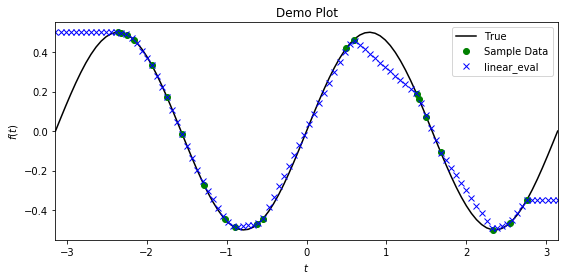

In [7]:
def linear_eval(t, y, t_star):
    """Use a piece-wise linear reconstruction to evaluate a guess at what t_star is
    
    Let y_i = f(t_i), using a linear function between the data points (t_i, y_i)
    as an estimate for f(t_star).
    
    :Input:
     - *t* (numpy.ndarray) Interpolant points.
     - *y* (numpy.ndarray) Function evaluation as interpolant points.
     - *t_star* (numpy.ndarray) Points to evaluate the interpolant at.
    
    :Output:
     - (numpy.ndarray) Corresponding P(t_star) where P is the new approximated
       function.
    """
    
    # If a float is passed then turn it into a numpy array
    if type(t_star) is float:
        t_star = numpy.array([t_star])
    
    y_star = numpy.zeros(numpy.shape(t_star))
    
    for idx, t_val in enumerate(t_star):
        # Check if the t_star value is outside t
        if t_val <= t[0]:
            y_star[idx] = y[0]
            continue
        elif t_val >= t[-1]:
            y_star[idx] = y[-1]
            continue
        
        # Find the value closest to the t_star value
        min_idx = numpy.argmin(numpy.abs(t - t_val))

        # Assume in order t list. Evaluate the 3 possible
        # cases for the minimum value and then use numpy.interp
        if t[min_idx] == t_val:
            # Case where t_star is in the list
            y_star[idx] = y[min_idx]
        elif t[min_idx - 1] < t_val < t[min_idx]:
            # Case where t_star is closet to the value on its left
            y_star[idx] = numpy.interp(
                t_val, t[min_idx - 1 : min_idx + 1], 
                y[min_idx - 1 : min_idx + 1])
        elif t[min_idx] < t_val < t[min_idx + 1]:
            # Case where t_star is closet to the value on its right
            y_star[idx] = numpy.interp(
                t_val, t[min_idx : min_idx + 2], 
                y[min_idx : min_idx + 2])   
        else:
            raise ValueError("t array must be in order")
    return y_star

N = 20
t_fine = numpy.linspace(-numpy.pi, numpy.pi, 100)
t_rand = numpy.random.rand(N + 1) * (2.0 * numpy.pi) - numpy.pi
t_rand.sort()
f = lambda x: numpy.sin(x) * numpy.cos(x)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth()*1.5)
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_fine, f(t_fine), 'k-', label="True")
axes.plot(t_rand, f(t_rand), 'og', label="Sample Data")
axes.plot(t_fine, linear_eval(t_rand, f(t_rand), t_fine), 'xb', label="linear_eval")
axes.set_xlim((-numpy.pi, numpy.pi))
axes.set_title("Demo Plot")
axes.set_xlabel('$t$')
axes.set_ylabel('$f(t)$')
axes.legend()
plt.show()

In [8]:
N = 100
f = lambda x: numpy.sin(x) * numpy.cos(x)
t = numpy.linspace(-1, 1, N + 1)
t_star = 0.5
answer = linear_eval(t, f(t), t_star)
if isinstance(answer, list):
    answer = answer[0]
print("Computed solution: %s" % answer)
print("True solution: %s" % f(t_star))
numpy.testing.assert_almost_equal(answer, f(t_star), verbose=True, decimal=7)
print("Success!")

Computed solution: [ 0.42073549]
True solution: 0.420735492404
Success!


**(b)** (10 points) Using the function you wrote in part (a) write a function that uses Golden search to find the maximum of a series of data.  Again you can use the plotting code available if your `linear_eval` function from part (a) handles arrays.

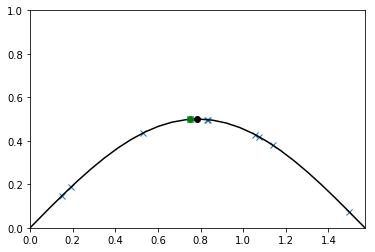

In [9]:
from scipy.constants import golden

def golden_search(bracket, t, y, max_steps=100, tolerance=1e-4):
    """
    Maximize a series of data using the golden search algorithm. Uses linear interpolation
    to interpolate between points in the time series. Preforms the algorithm until
    the bracket is smaller than the tolerance or the maximum number of steps has been reached.
    Assumes the function is well behaved in the given bracket, but will not raise if it
    is not.
    
    Parameters
    ----------
    bracket: list of floats
        Original bracket to search in form [lower, upper]
    t: list of floats
        The timeseries to maximize
    y: list of floats
        The function values at each of the time points
    max_steps: opt int
        The maximum number of times to run the algorithm
    tolerance: opt float
        The minimum bracket size before returning
    
    Returns
    -------
    float: The value of t where y is maximized
    
    """
    
    # Here we set f as our linear interpolator
    f = lambda x: linear_eval(t, y, x)
    
    # bracket lower bound
    bl = bracket[0]
    
    # bracket upper bound
    bu = bracket[1]
    
    # search points lower bound
    xl = bu - (bu - bl) / golden

    # search points upper bound
    xu = bl + (bu - bl) / golden
    
    steps = 0
    while numpy.abs(bu - bl) > tolerance and steps < max_steps:
        # This condition is switched from class as we are now maximizing
        if f(xl) > f(xu):
            # Move upper bound to search upper
            bu = xu
        else:
            # Move lower bound to search lower
            bl = xl
        
        # Recalculate the search points
        xl = bu - (bu - bl) / golden
        xu  = bl + (bu - bl) / golden
        steps += 1
        
    # Return the bracket midpoint
    return (bu + bl) / 2

N = 50
t = numpy.random.rand(N + 1) * (2.0 * numpy.pi) - numpy.pi
t.sort()
y = numpy.sin(t) * numpy.cos(t)
t_star = golden_search([0.1, 3.0 * numpy.pi / 4.0], t, y)
t_true = numpy.pi / 4.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t, y, 'x', label="data")
t_fine = numpy.linspace(-numpy.pi, numpy.pi, 100)
axes.plot(t_fine, numpy.sin(t_fine) * numpy.cos(t_fine), 'k', label="$f(x)$")
axes.plot(t_star, linear_eval(t, y, t_star), 'go')
axes.plot(t_true, numpy.sin(t_true) * numpy.cos(t_true), 'ko', label="True")
axes.set_xlim((0.0, numpy.pi / 2.0))
axes.set_ylim((0.0, 1.0))
plt.show()

In [10]:
N = 100
t = numpy.random.rand(N + 1) * (2.0 * numpy.pi) - numpy.pi
t.sort()
y = numpy.sin(t) * numpy.cos(t)
t_star = golden_search([0.1, 3.0 * numpy.pi / 4.0], t, y)
t_true = numpy.pi / 4.0
abs_error = numpy.abs(t_star - t_true)
rel_error = numpy.abs(t_star - t_true) / numpy.abs(t_true)
print("Error: %s, %s" % (abs_error, rel_error))
numpy.testing.assert_allclose(abs_error, 0.0, rtol=1e-1, atol=1e-1)
print("Success!")

Error: 0.0110372272071, 0.0140530341443
Success!


**(c)** (5 points) Below is sample code that plots the number of sample points $N$ vs. the relative error.  Note because we are sampling at random points that we do each $N$ 6 times and average the relative error to reduce noise.  Additionally a line is drawn representing what would be linear (1st order) convergence.

Modify this code and try it out on other problems.  Do you continue to see linear convergence?  What about if you change how we sample points?  Make sure that you change your initial interval and range of values of $t$ inside the loop.

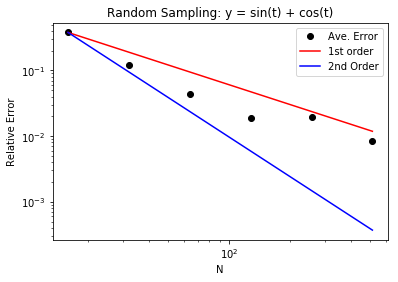

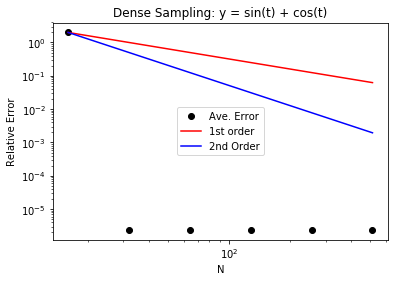

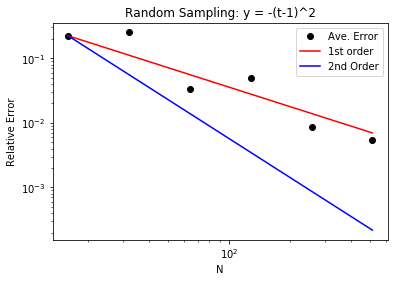

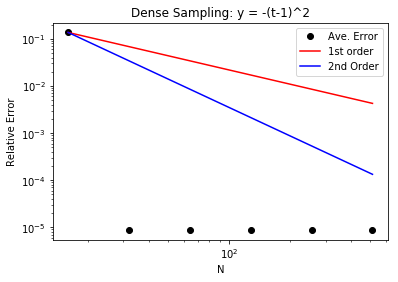

In [11]:
# Global N_range
N_range = numpy.array([2**n for n in range(4, 10)], dtype=int)

def gen_rel_error(f, t_range, search_bounds, t_true, normal_smpl):
    """
    Generate a relitive error for given test parameters. There are two ways 
    this function can sample t. The first is random sampling over the range of t.
    The second is sampling 90% of t within +/- 0.0001 percent of the true value.
    This behavior is controled by the normal_smpl flag. It runs each trial
    6 times and averages the results
    
    Parameter
    ---------
    f: func
        The function we are maximizing
    t_range: list
        The range of t values to sample [t_lower, t_upper]
    search_bounds: list
        The bounds we are searching for the max in [search_lower, search_upper]
    t_true: float
        The true value of t we are looking for
    normal_smpl: bool
        Flag indicating whether to sample normally. If true, randomly sample within the t_range. If false we sample
        90% of the points within +/- 0.0001 of the true value
        
    Returns
    -------
    rel_error: float
        The average relative error
        
    """
    rel_error = numpy.zeros(len(N_range))
    for (i, N) in enumerate(N_range):
            for j in range(6):
                if normal_smpl:
                    t = numpy.random.uniform(low=t_range[0], high=t_range[1], size=(N+1,))
                    t.sort()
                else:
                    # Percent of points sampled +/- sample range of the true value
                    mid_percent = 0.9
                    
                    # +/- range of true from sampling
                    smpl_range = 0.0001
                    
                    # Sample the points and then concat them
                    ul_percent = (1 - mid_percent) / 2
                    t_u = numpy.random.uniform(
                        low=t_true + smpl_range, high=t_range[1], size=(int(N * ul_percent),))
                    t_m = numpy.random.uniform(
                        low=t_true - smpl_range, high=t_true + smpl_range, size=(int(N * mid_percent),))
                    t_l = numpy.random.uniform(
                        low=t_range[0], high=t_true - smpl_range, size=(int(N * ul_percent),))
                    t = numpy.unique(numpy.concatenate((t_l, t_m, t_u), axis=0))
                    
                y = f(t)
                t_star = golden_search(search_bounds, t, y)
                rel_error[i] += numpy.abs(t_star - t_true) / numpy.abs(t_true)
            rel_error[i] /= 6
    return rel_error    

# Parameters for different test trials

# sin(t)cos(t) random sampling
f_1 = (lambda t: numpy.sin(t) * numpy.cos(t), 
       [-numpy.pi, numpy.pi], 
       [0.1, 3.0 * numpy.pi / 4.0], 
       numpy.pi / 4.0, 
       True)

# sin(t)cos(t) dense sampling
f_1_cs = (lambda t: numpy.sin(t) * numpy.cos(t), 
           [-numpy.pi, numpy.pi], 
           [0.1, 3.0 * numpy.pi / 4.0], 
           numpy.pi / 4.0, 
           False)

# -(t-1.1)^2 random sampling
f_2 = (lambda t:-(t-1.1)**2,
           [-5, 5], 
           [0, 2], 
           1.1, 
           True)



# -(t-1.1) dense sampling
f_2_cs = (lambda t:-(t-1.1)**2,
           [-5, 5], 
           [0, 2], 
           1.1, 
           False)

# Get errors for each of the trials
rel_errors = []
f_list = [f_1, f_1_cs, f_2, f_2_cs]
for f, t_range, search_bounds, t_true, normal_smpl in f_list:
    rel_errors.append(gen_rel_error(f, t_range, search_bounds, t_true, normal_smpl))

# Plot the results
titles = ['Random Sampling: y = sin(t) + cos(t)', 'Dense Sampling: y = sin(t) + cos(t)', 
         'Random Sampling: y = -(t-1)^2', 'Dense Sampling: y = -(t-1)^2']
for name, rel_error in zip(titles, rel_errors):
    order_C = lambda N, error, order: numpy.exp(numpy.log(error) - order * numpy.log(N))    
    fig = plt.figure()
    plt.title(name)
    axes = fig.add_subplot(1, 1, 1)
    axes.loglog(N_range, rel_error, 'ko', label="Ave. Error")
    axes.loglog(N_range, order_C(N_range[0], rel_error[0], -1.0) * N_range**(-1.0), 'r', label="1st order")
    axes.loglog(N_range, order_C(N_range[0], rel_error[0], -2.0) * N_range**(-2.0), 'b', label="2nd Order")
    axes.set_xlabel("N")
    axes.set_ylabel("Relative Error")
    axes.legend()


   Since we are finding the maximum with piecewise interpolation, all we are really doing is finding the maximum value of y given the values of t. Thus if we sample densely around the true value and loosly for the rest of the t range, we can see much faster than linear convergence. This is because, since there are more points clustered around the true value of t, we can be assured that value very close to the true t will be sampled. Here we show this by running the function on randomly sampled points followed by running it on points where 90% of the points are sampled within +/-0.0001 of the true value. When we do this dense sampling we see much quicker convergence than the randomly sampled points.